In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6VZ92V/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6VZ92V/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6VZ92V/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_examples_batch, train_labels_batch = next(iter(train_dataset))

In [4]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [5]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [6]:
assert original_string == sample_string
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
__________________________________________________

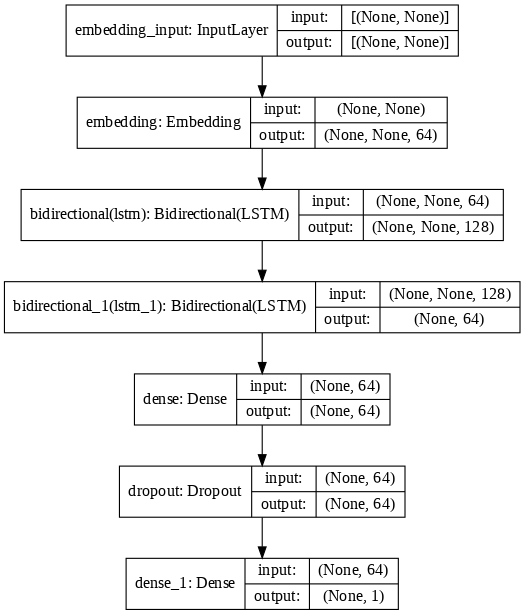

In [10]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True, dpi=80)

In [11]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

In [12]:
history = model.fit(train_dataset, epochs = 10, validation_data = test_dataset, validation_steps = 30)

Epoch 1/10
391/391 [==============================] - 1650s 4s/step - loss: 0.6590 - accuracy: 0.5448 - val_loss: 0.5360 - val_accuracy: 0.7573
Epoch 2/10
391/391 [==============================] - 1616s 4s/step - loss: 0.4123 - accuracy: 0.8184 - val_loss: 0.4111 - val_accuracy: 0.7896
Epoch 3/10
391/391 [==============================] - 1618s 4s/step - loss: 0.3161 - accuracy: 0.8782 - val_loss: 0.3561 - val_accuracy: 0.8380
Epoch 4/10
391/391 [==============================] - 1620s 4s/step - loss: 0.2527 - accuracy: 0.9074 - val_loss: 0.3489 - val_accuracy: 0.8422
Epoch 5/10
391/391 [==============================] - 1633s 4s/step - loss: 0.2150 - accuracy: 0.9270 - val_loss: 0.4396 - val_accuracy: 0.8182
Epoch 6/10
391/391 [==============================] - 1614s 4s/step - loss: 0.1914 - accuracy: 0.9362 - val_loss: 0.3579 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 1609s 4s/step - loss: 0.1661 - accuracy: 0.9478 - val_loss: 0.3713 - val_accuracy:

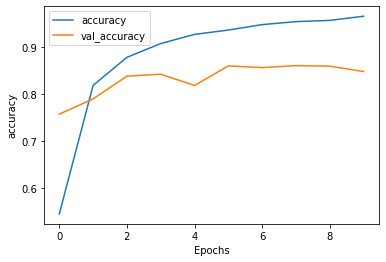

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

plot_graphs(history, 'accuracy')

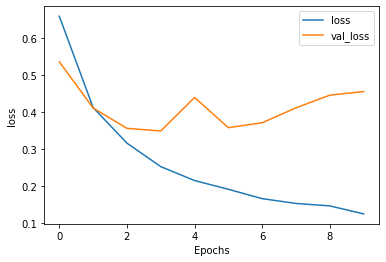

In [14]:
plot_graphs(history, 'loss')

**Test For Accuracy**

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 351s 898ms/step - loss: 0.4689 - accuracy: 0.8438
Test Loss: 0.4688892662525177
Test Accuracy: 0.8437600135803223


In [16]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [17]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  print("Prediction Score: ", predictions)
  output = ""
  if predictions[0][0] >= 0.5: output = "POSITIVE"
  elif predictions[0][0] <= -1: output = "NEGATIVE"
  else: output = "NEUTRAL"

  return output

**Prediction with Sample Sentiments**

In [18]:
sample_pred_text = ('The movie was not good. The graphics was terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-1.7859391]]
NEGATIVE


In [26]:
sample_pred_text = ('The movie was very good. The animation and the graphics were out of the world')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[0.7087732]]
POSITIVE


In [20]:
sample_pred_text = ('Overrated but good')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[0.24255261]]
NEUTRAL


In [21]:
sample_pred_text = ('This movie was so so. The acting was medicore. Kind of recommend')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[0.18905787]]
NEUTRAL


In [28]:
sample_pred_text = ('Absolutely terrible writing and dragged-out unnecessary dialogue')

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[-1.5297097]]
NEGATIVE


In [36]:
sample_pred_text = ("Loved the movie. brilliant")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

Prediction Score:  [[0.50894576]]
POSITIVE
